In [7]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
from scipy.optimize import curve_fit

In [ ]:
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_133235.ttbin' #QD_18 (PW) (Antibunching 0.596)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_135704.ttbin' #QD_20 (PW) (Antibunching 0.785)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_141548.ttbin' #QD_21 (PW) (Antibunching 0.538)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_163955.ttbin' #QD_23 (PW 1) (Antibunching 0.810)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_164301.ttbin' #QD_23 (PW 2) (Antibunching 0.732)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_170035.ttbin' #QD_23 (PW 3) (Antibunching 0.715)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_171013.ttbin' #QD_23 (PW 4) (Antibunching 0.857)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_172322.ttbin' #QD_24 (PW) (Antibunching 0.492)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_143420.ttbin' #QD_27 (PW) (Antibunching 0.741)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_144431.ttbin' #QD_28 (PW) (Antibunching 0.609)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_153714.ttbin' #QD_29 (PW) (Antibunching 0.308)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-07_100735.ttbin' #QD_30 (PW) (Antibunching 0.254)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-17_124542.ttbin' #QD_36 (PW) (Antibunching 0.344) (0.2 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-17_125253.ttbin' #QD_37 (PW) (Antibunching 0.344) (0.3 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-17_132341.ttbin' #QD_40 (PW) (Antibunching 0.269) (0.2 uW)


In [65]:
fr = FileReader(file)
print("All channels available: {}".format(fr.getChannelList()))

print("Has data? ->", fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (1, 2)
Has data? -> True


In [66]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-02-26 12:39:29 +0100
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

In [67]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

{'configure version': 1,
 'current time': '2025-05-13 15:56:42 +0200',
 'hardware configuration': None,
 'measurements': [],
 'replay speed': -1.0,
 'software clock': None,
 'software version': '2.17.4',
 'virtual inputs': []}


Correlation measurement is running.

Rate of counts channel 1 (counts/sec) : 36922.51945648774
Total counts channel 1 : 6878799
Rate of counts channel 2 (counts/sec) : 40306.17889982027
Total counts channel 2 : 7509187


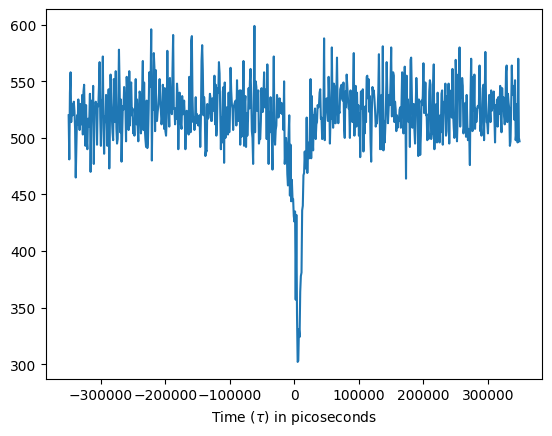

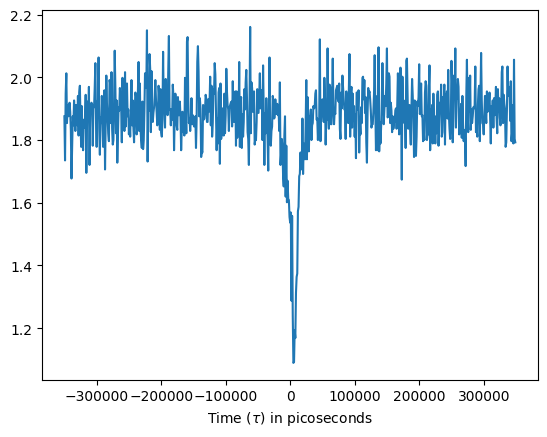

In [68]:
# measure photon antibunching
corr_ch1 = config['registered channels'][0] # first photon channel for antibunching measurements
corr_ch2 = config['registered channels'][1] # second photon channel for antibunching measurements
bwcorr = 1000 # 1 ns
nbins = 700

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])
print("\nCorrelation measurement is running.\n")


virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
#virtual_tagger.replay(file, duration=8*10e11) # collect only 1 sec. of data (duration in picoseconds)
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr = corr.getIndex()
ycorr_norm = corr.getDataNormalized()
ycorr = corr.getData()

rate_ch1 = cr.getData()[0]
rate_ch2 = cr.getData()[1]
counts_ch1 = cr.getCountsTotal()[0]
counts_ch2 = cr.getCountsTotal()[1]

print(f"Rate of counts channel {corr_ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Total counts channel {corr_ch1} : {cr.getCountsTotal()[0]}")
print(f"Rate of counts channel {corr_ch2} (counts/sec) : {cr.getData()[1]}")
print(f"Total counts channel {corr_ch2} : {cr.getCountsTotal()[1]}")

plt.plot(xcorr, ycorr)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

plt.plot(xcorr, ycorr_norm)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

In [63]:
# Normalize counts 
capture_duration = np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]) * 1e12 # Capture duration in picoseconds
print("Capture duration (seconds): ", np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]))

counts_normalized = (ycorr  * capture_duration)/(bwcorr * counts_ch1 * counts_ch2) 

Capture duration (seconds):  144.387612672


In [52]:
rep_rate = 200 #ns (Repetition rate of the pulsed laser)

In [53]:
# Define the fitting function: 
def fitting_function(tau, a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right):
    return a + (b_left * np.exp(-np.abs(tau - t_0_left) / tau_0_left)) + (b * np.exp(-np.abs(tau - t_0) / tau_0)) + (b_right * np.exp(-np.abs(tau - t_0_right) / tau_0_right))


# Function to normalize counts and fit the data
def fit_noblinking(tau, counts):
    # Initial parameter guess [a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right]
    global rep_rate
    p0 = [1, 1, -rep_rate, 5, 5, 1, 5, 1, rep_rate, 5]
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts, p0=p0)
    
    return popt, pcov

# Function to plot the normalized data and the fitted curve
def plot_fit_noblinking(tau, counts, params, width, height, font_size):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts, linestyle='-', color='black', linewidth=0.7, label='Normalized Data')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 1000000)
    fitted_curve = fitting_function(tau_fine, *params)
    
    # Plot fitted curve
    plt.plot(tau_fine, fitted_curve, 'g-', label='Fitted Curve')
    
    # Etiquetas de los ejes con tamaño de fuente modificado
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # plt.legend()
    plt.grid(True)
    plt.show()

## Obtention of non-normalized graph

In [54]:
params, pcov = fit_noblinking(xcorr/1000, ycorr)

# Calculate the standard deviations of the parameters
perr = np.sqrt(np.diag(pcov))

print(f"a: {params[0]:.3f} ± {perr[0]:.3f} counts")
print(f"b_left: {params[1]:.3f} ± {perr[1]:.3f} counts")
print(f"t_0_left: {params[2]:.3f} ± {perr[2]:.3f} ns")
print(f"tau_0_left: {params[3]:.3f} ± {perr[3]:.3f} ns \n")

print(f"b: {params[4]:.3f} ± {perr[4]:.3f} counts")
print(f"t_0: {params[5]:.3f} ± {perr[5]:.3f} ns")
print(f"tau_0: {params[6]:.3f} ± {perr[6]:.3f} ns \n")

print(f"b_right: {params[7]:.3f} ± {perr[7]:.3f} counts")
print(f"t_0_right: {params[8]:.3f} ± {perr[8]:.3f} ns")
print(f"tau_0_right: {params[9]:.3f} ± {perr[9]:.3f} ns \n")

a: 4.614 ± 0.651 counts
b_left: 0.569 ± 0.536 counts
t_0_left: -120.000 ± 48.464 ns
tau_0_left: 92.989 ± 279.203 ns 

b: -0.592 ± 0.594 counts
t_0: -8.000 ± 20.847 ns
tau_0: 30.955 ± 64.189 ns 

b_right: 0.418 ± 0.630 counts
t_0_right: 259.000 ± 59.447 ns
tau_0_right: 106.720 ± 257.818 ns 



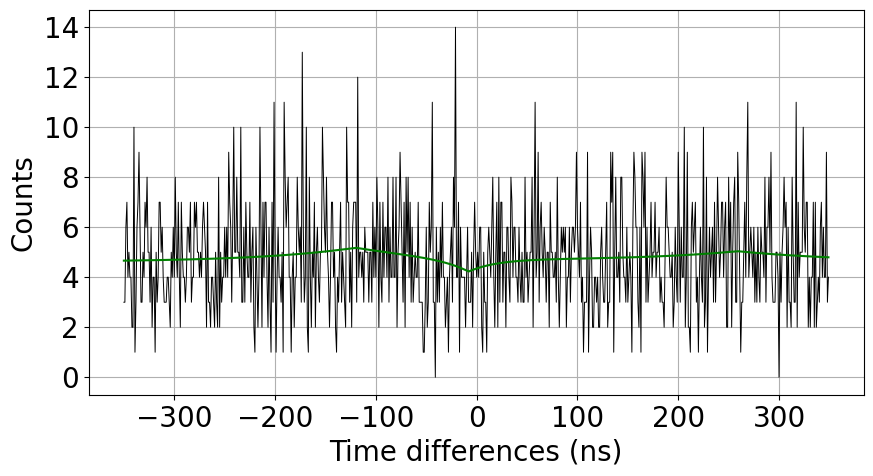

In [55]:
# Plot the normalized data and the fitted curve
plot_fit_noblinking(xcorr/1000, ycorr, params, width=10, height=5, font_size=20)

## Obtention of the normalized graph

In [56]:
popt, pcov = fit_noblinking(xcorr/1000, counts_normalized)
# Extract fitted parameters
a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right = popt

counts_normalized = 2 * counts_normalized/ (b_left + b_right)

params, pcov = fit_noblinking(xcorr/1000, counts_normalized)

# Calculate the standard deviations of the parameters
perr = np.sqrt(np.diag(pcov))

print(f"a: {params[0]:.3f} ± {perr[0]:.3f} counts")
print(f"b_left: {params[1]:.3f} ± {perr[1]:.3f} counts")
print(f"t_0_left: {params[2]:.3f} ± {perr[2]:.3f} ns")
print(f"tau_0_left: {params[3]:.3f} ± {perr[3]:.3f} ns \n")

print(f"b: {params[4]:.3f} ± {perr[4]:.3f} counts")
print(f"t_0: {params[5]:.3f} ± {perr[5]:.3f} ns")
print(f"tau_0: {params[6]:.3f} ± {perr[6]:.3f} ns \n")

print(f"b_right: {params[7]:.3f} ± {perr[7]:.3f} counts")
print(f"t_0_right: {params[8]:.3f} ± {perr[8]:.3f} ns")
print(f"tau_0_right: {params[9]:.3f} ± {perr[9]:.3f} ns \n")

a: 5.000 ± 2.597 counts
b_left: 0.961 ± 2.178 counts
t_0_left: -152.073 ± 58.273 ns
tau_0_left: 209.066 ± 839.237 ns 

b: -0.777 ± 0.754 counts
t_0: -9.206 ± 15.911 ns
tau_0: 23.356 ± 46.822 ns 

b_right: 0.819 ± 1.510 counts
t_0_right: 269.000 ± 75.816 ns
tau_0_right: 206.964 ± 407.375 ns 



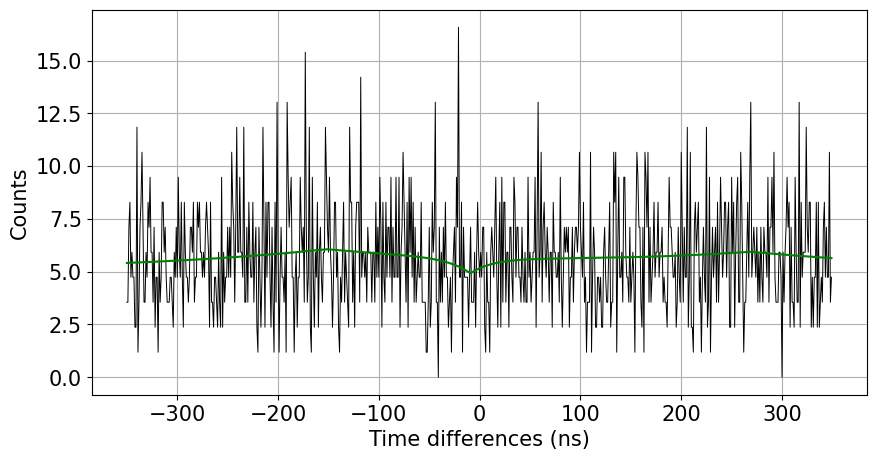

In [57]:
# Plot the normalized data and the fitted curve
plot_fit_noblinking(xcorr/1000, counts_normalized, params, width=10, height=5, font_size=15)

In [45]:
print(f"Normalized g^(2)(tau = 0): {(params[0] + params[4]):.3f} ± {np.sqrt((perr[0]**2 + perr[4]**2)):.3f}")

Normalized g^(2)(tau = 0): 0.269 ± 0.026
